# Problem statement

- To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

- The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.


The data set contains the following diseases:

  - Actinic keratosis
  - Basal cell carcinoma
  - Dermatofibroma
  - Melanoma
  - Nevus
  - Pigmented benign keratosis
  - Seborrheic keratosis
  - Squamous cell carcinoma
  - Vascular lesion

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip /content/gdrive/MyDrive/Upgrad/Colab/CNN_Assignment/Skin_Cancer_Dataset.zip -d /content/gdrive/MyDrive/Upgrad/Colab/CNN_Assignment

Archive:  /content/gdrive/MyDrive/Upgrad/Colab/CNN_Assignment/Skin_Cancer_Dataset.zip
  inflating: /content/gdrive/MyDrive/Upgrad/Colab/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: /content/gdrive/MyDrive/Upgrad/Colab/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /content/gdrive/MyDrive/Upgrad/Colab/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: /content/gdrive/MyDrive/Upgrad/Colab/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: /content/gdrive/MyDrive/Upgrad/Colab/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: /content/gdrive/MyDrive/Upgrad/Colab/CNN_Assignment/Skin

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Upgrad/Colab/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Upgrad/Colab/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
!ls

gdrive	sample_data


In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing
Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [11]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [12]:
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))

32
32


32
32


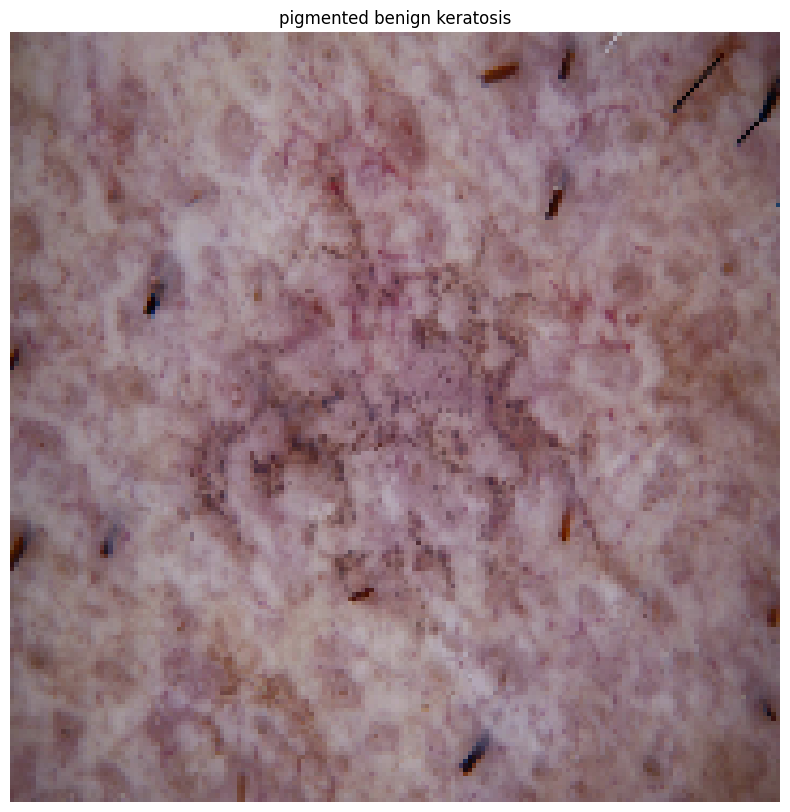

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  print(len(images))
  print(len(labels))
  plt.imshow(images[10].numpy().astype("uint8"))
  plt.title(class_names[labels[10]])
  plt.axis("off")

### Visualize the data

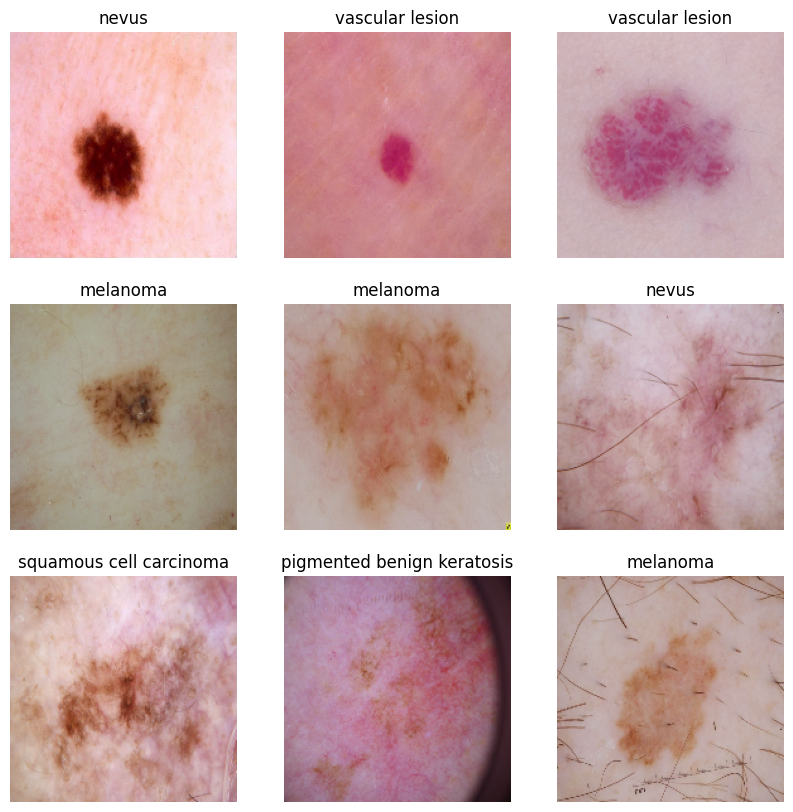

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [15]:
#overlaps data preprocessing and model execution while training., Speed up training
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [16]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

In [17]:
### choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [19]:
#Fit the model and run it for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 25s 89ms/step - loss: 2.0734 - accuracy: 0.2081 - val_loss: 1.9012 - val_accuracy: 0.3221
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 1.7091 - accuracy: 0.3984 - val_loss: 1.5496 - val_accuracy: 0.4899
Epoch 3/20
56/56 [==============================] - 1s 21ms/step - loss: 1.4619 - accuracy: 0.4883 - val_loss: 1.4953 - val_accuracy: 0.5123
Epoch 4/20
56/56 [==============================] - 1s 21ms/step - loss: 1.3408 - accuracy: 0.5329 - val_loss: 1.4560 - val_accuracy: 0.5190
Epoch 5/20
56/56 [==============================] - 1s 21ms/step - loss: 1.2435 - accuracy: 0.5664 - val_loss: 1.3806 - val_accuracy: 0.5436
Epoch 6/20
56/56 [==============================] - 1s 21ms/step - loss: 1.1664 - accuracy: 0.5714 - val_loss: 1.3567 - val_accuracy: 0.5436
Epoch 7/20
56/56 [==============================] - 1s 21ms/step - loss: 1.0742 - accuracy: 0.6205 - val_loss: 1.4388 - val_accuracy: 0.5436
Epoch 8/20
5

### Visualizing training results

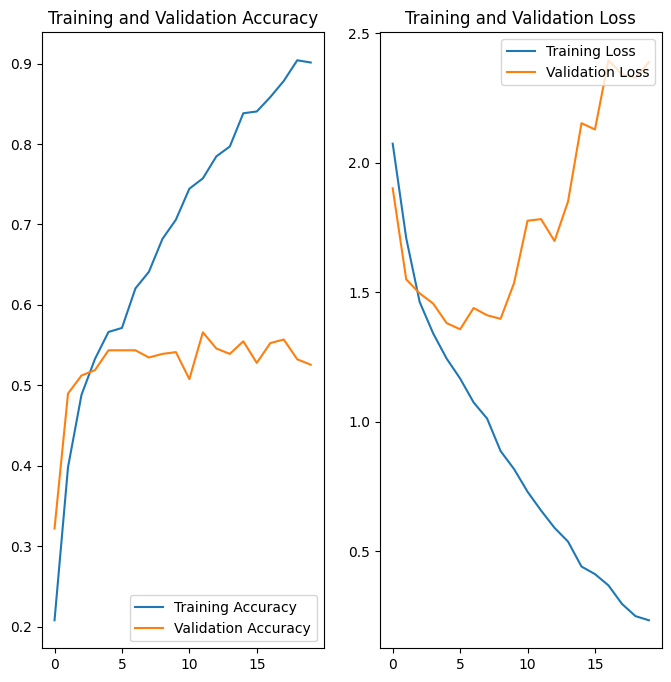

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
num_classes = 9

# Increasing the number of filters in the convolution layers
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [22]:
### Choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

### Train the model

In [24]:
#Fit the model and run it for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 81ms/step - loss: 2.0747 - accuracy: 0.2003 - val_loss: 2.0141 - val_accuracy: 0.2640
Epoch 2/20
56/56 [==============================] - 3s 61ms/step - loss: 1.8109 - accuracy: 0.3499 - val_loss: 1.5714 - val_accuracy: 0.4228
Epoch 3/20
56/56 [==============================] - 3s 61ms/step - loss: 1.5114 - accuracy: 0.4643 - val_loss: 1.4606 - val_accuracy: 0.4765
Epoch 4/20
56/56 [==============================] - 3s 60ms/step - loss: 1.3643 - accuracy: 0.5073 - val_loss: 1.4667 - val_accuracy: 0.5347
Epoch 5/20
56/56 [==============================] - 3s 62ms/step - loss: 1.3875 - accuracy: 0.5095 - val_loss: 1.4351 - val_accuracy: 0.5168
Epoch 6/20
56/56 [==============================] - 3s 60ms/step - loss: 1.2768 - accuracy: 0.5474 - val_loss: 1.4225 - val_accuracy: 0.4855
Epoch 7/20
56/56 [==============================] - 3s 60ms/step - loss: 1.1781 - accuracy: 0.5926 - val_loss: 1.4237 - val_accuracy: 0.5302
Epoch 8/20
56

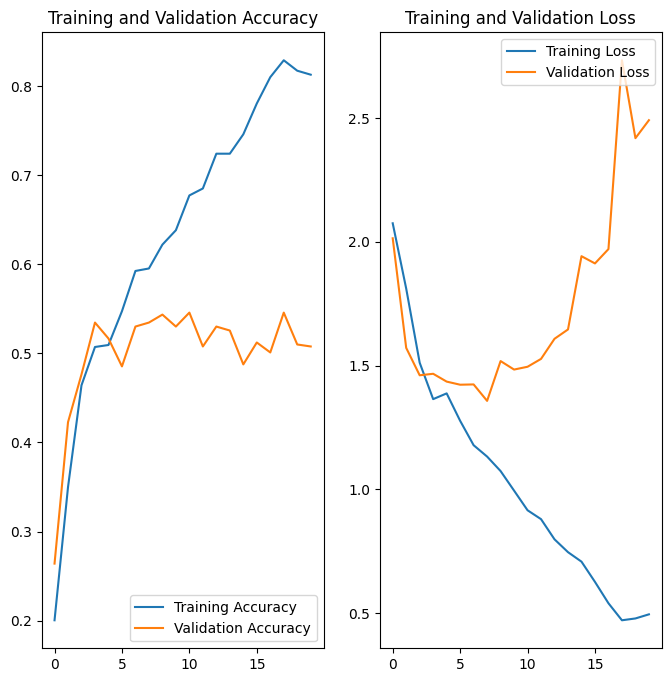

In [25]:
# Visualizing the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings

- We observed that the model has clearly overfit as there is a huge difference in accuracy between training dataset and validation dataset
- Also we noticed that increasing the number of filters in convolution layers also didn't help and it has brought down both training and validation accuracy slightly
- As the model is overfitting, we will try to augment the data next and see how it works

In [26]:
# Performing appropriate data augumentations to avoid the issue of overfitting.
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.experimental.preprocessing.RandomCrop(img_height,img_width),
  ]
)

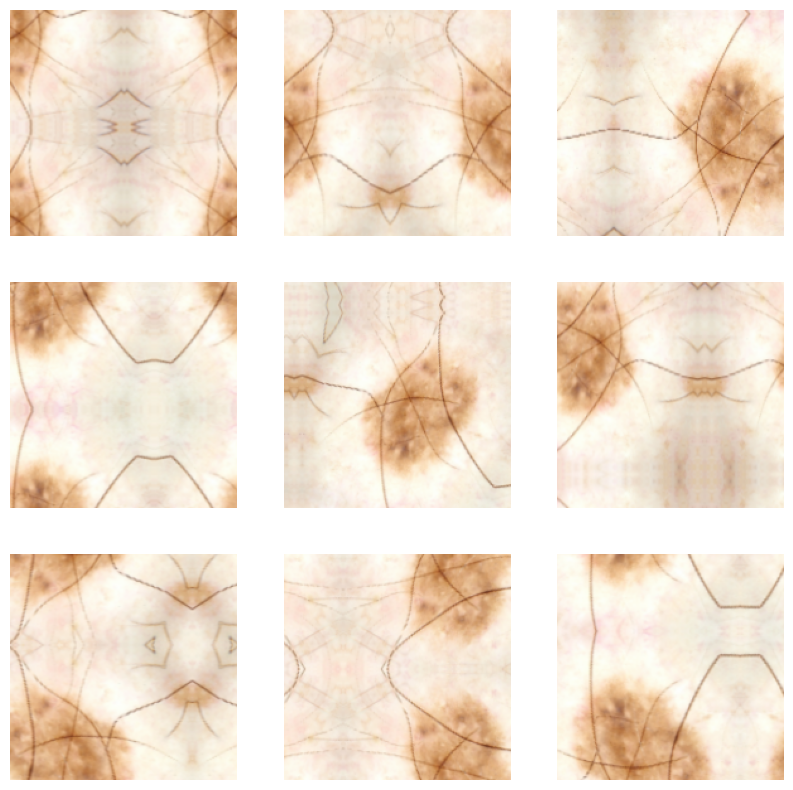

In [27]:
# Visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model, compile and train the model after data augmentation

In [28]:
# Creating the model

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Using dropout layer as there is clear evidence of overfitting
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [29]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 12s 133ms/step - loss: 2.2525 - accuracy: 0.2070 - val_loss: 2.0542 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 7s 118ms/step - loss: 1.9234 - accuracy: 0.2751 - val_loss: 1.7792 - val_accuracy: 0.3221
Epoch 3/20
56/56 [==============================] - 7s 119ms/step - loss: 1.7885 - accuracy: 0.3292 - val_loss: 1.6678 - val_accuracy: 0.4004
Epoch 4/20
56/56 [==============================] - 7s 116ms/step - loss: 1.6974 - accuracy: 0.3465 - val_loss: 1.7911 - val_accuracy: 0.3266
Epoch 5/20
56/56 [==============================] - 7s 118ms/step - loss: 1.7388 - accuracy: 0.3510 - val_loss: 1.6321 - val_accuracy: 0.3602
Epoch 6/20
56/56 [==============================] - 6s 116ms/step - loss: 1.6489 - accuracy: 0.3934 - val_loss: 1.6252 - val_accuracy: 0.4183
Epoch 7/20
56/56 [==============================] - 7s 117ms/step - loss: 1.6466 - accuracy: 0.3756 - val_loss: 1.7675 - val_accuracy: 0.3400
Epoch

### Visualizing the results

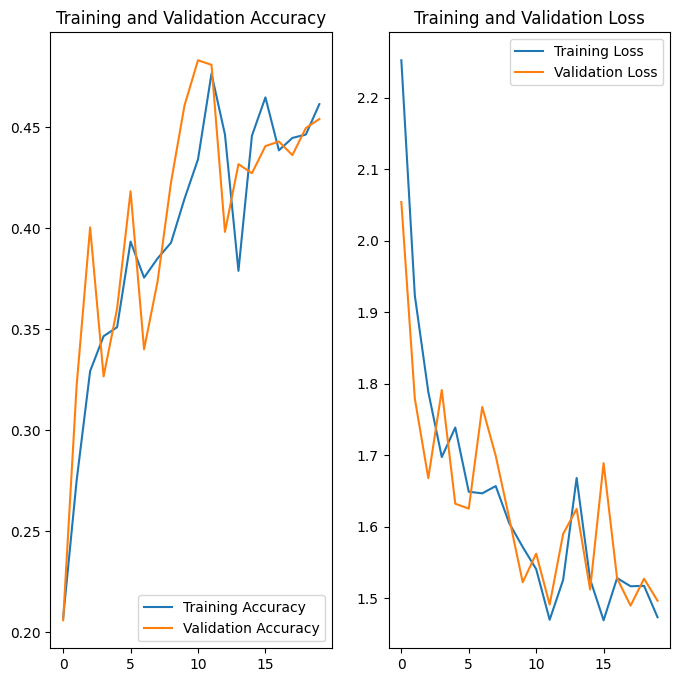

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings
- Our model hasn't improved from the previous run, infact accuracy scores have come down
- Also the model seem to be overfitting clearly

#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [32]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [33]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df.head()

,Path,Label
0,/content/gdrive/MyDrive/Upgrad/Colab/CNN_Assig...,actinic keratosis
1,/content/gdrive/MyDrive/Upgrad/Colab/CNN_Assig...,actinic keratosis
2,/content/gdrive/MyDrive/Upgrad/Colab/CNN_Assig...,actinic keratosis
3,/content/gdrive/MyDrive/Upgrad/Colab/CNN_Assig...,actinic keratosis
4,/content/gdrive/MyDrive/Upgrad/Colab/CNN_Assig...,actinic keratosis


- Checking which classes have least number of samples and which classes dominate the data in terms of proportionate number of samples

Class=0, n=114 (5.092%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)


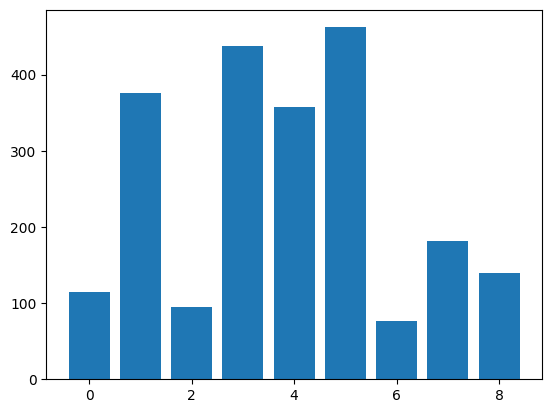

In [34]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [35]:
folders = ([name for name in os.listdir(data_dir_train)
            if os.path.isdir(os.path.join(data_dir_train, name))])
for folder in folders:
    contents = os.listdir(os.path.join(data_dir_train,folder))
    print(folder+":"+str(len(contents)))

actinic keratosis:114
basal cell carcinoma:376
dermatofibroma:95
melanoma:438
nevus:357
pigmented benign keratosis:462
seborrheic keratosis:77
squamous cell carcinoma:181
vascular lesion:139


### Findings
- Class `seborrheic keratosis` has least number of samples followed by `dermatofibroma` and `actinic keratosis`
- With respect to dominant classes, it is `pigmented benign keratosis` and `melanoma`

## Rectifying the class imbalance

#### **Context:** We will be using python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [36]:
!pip install Augmentor

In [37]:
path_to_training_dataset= "/content/gdrive/MyDrive/Upgrad/Colab/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Colab/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B0C604137F0>: 100%|██████████| 500/500 [00:22<00:00, 21.84 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Colab/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B0C60262C50>: 100%|██████████| 500/500 [00:23<00:00, 20.86 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Colab/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B0C6E678FD0>: 100%|██████████| 500/500 [00:18<00:00, 26.48 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Colab/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B0C60283580>: 100%|██████████| 500/500 [01:17<00:00,  6.49 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Colab/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7B0C602B1DE0>: 100%|██████████| 500/500 [01:24<00:00,  5.94 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Colab/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B0C60410610>: 100%|██████████| 500/500 [00:19<00:00, 25.96 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Colab/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B0C7A133070>: 100%|██████████| 500/500 [00:36<00:00, 13.59 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Colab/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B0C603E5C60>: 100%|██████████| 500/500 [00:19<00:00, 26.05 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/Colab/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B0C60411C30>: 100%|██████████| 500/500 [00:18<00:00, 27.34 Samples/s]


`Augmentor` has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. Lets take a look at total count of augmented images.

In [38]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [39]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#Displaying first 10 items
path_list[:10]

['/content/gdrive/MyDrive/Upgrad/Colab/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025825.jpg_0427348c-e2e7-412a-8bfe-a2bfe3a67813.jpg',
 '/content/gdrive/MyDrive/Upgrad/Colab/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030826.jpg_fd20a0b1-edb1-43bc-822f-7409951772e4.jpg',
 '/content/gdrive/MyDrive/Upgrad/Colab/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029659.jpg_77b3f3ca-de9f-4670-9ecf-ad1b20f939c1.jpg',
 '/content/gdrive/MyDrive/Upgrad/Colab/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031381.jpg_3de39f24-2ba3-4daa-b093-61bad19f345d.jpg',
 '/content/gdrive/MyDrive/Upgrad/Colab/CNN_Assignment/Skin cance

In [40]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#Displaying first 10
lesion_list_new[:10]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [41]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [42]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-42-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [43]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

- So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [44]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [45]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [46]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create the model (Include normalization)

In [47]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### Compile the  model

In [48]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train the model

In [49]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 58s 90ms/step - loss: 2.0191 - accuracy: 0.2413 - val_loss: 1.5669 - val_accuracy: 0.4031
Epoch 2/30
169/169 [==============================] - 5s 27ms/step - loss: 1.5285 - accuracy: 0.4190 - val_loss: 1.3443 - val_accuracy: 0.4915
Epoch 3/30
169/169 [==============================] - 5s 28ms/step - loss: 1.3634 - accuracy: 0.4896 - val_loss: 1.3090 - val_accuracy: 0.5219
Epoch 4/30
169/169 [==============================] - 5s 27ms/step - loss: 1.1974 - accuracy: 0.5486 - val_loss: 1.1619 - val_accuracy: 0.5716
Epoch 5/30
169/169 [==============================] - 5s 29ms/step - loss: 1.1113 - accuracy: 0.5835 - val_loss: 1.1716 - val_accuracy: 0.5642
Epoch 6/30
169/169 [==============================] - 5s 28ms/step - loss: 0.9709 - accuracy: 0.6417 - val_loss: 0.9470 - val_accuracy: 0.6644
Epoch 7/30
169/169 [==============================] - 5s 28ms/step - loss: 0.8309 - accuracy: 0.6960 - val_loss: 0.9665 - val_accuracy: 0.659

#### Visualize the model results

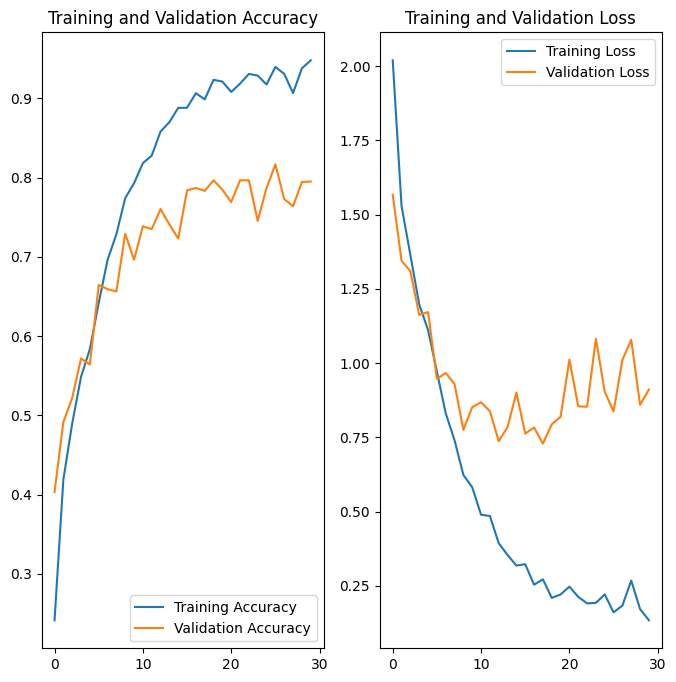

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings
- Yes, handling class imbalance did improve the accuracy
- Even the problem of overfitting is also resolved to an extent